<a href="https://colab.research.google.com/github/Prostotarakan/Lab_NNMO/blob/main/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.datasets import make_classification
import tensorflow as tf
from sklearn.datasets  import load_digits
from sklearn.model_selection import train_test_split as tts

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_completeness_v_measure



In [ ]:
D=6;

Выбор датасетов D=
* 1 - генерация линейно-разделимых множеств с большим расстоянием между группами
* 2 - генерация линейно-разделимых множеств с малым расстоянием между группами
* 3 - генерация линейно-неразделимых множеств с пересечением порядка 10%
* 4 - генерация линейно-неразделимых множеств с пересечением порядка 50%
* 5 - эталонный датасет fashion_mnist
* 6 - эталонный датасет digits

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '2 feature')

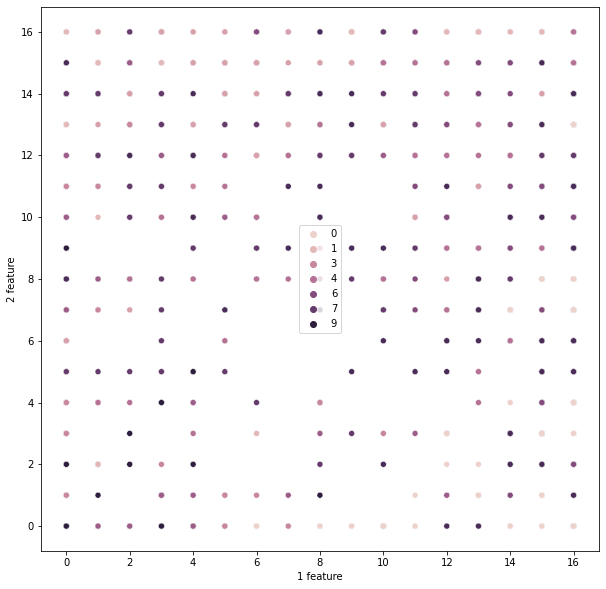

In [ ]:
K=4 #число классов
a=0 #информативные признаки
b=1
if D==1:
  x,y = make_classification(n_samples=1000, n_features=2,n_informative=2,n_redundant =0,n_clusters_per_class=1,n_classes=K, class_sep=100)
elif D==2:
  x,y = make_classification(n_samples=1000, n_features=2,n_informative=2,n_redundant =0,n_clusters_per_class=1,n_classes=K, class_sep=2)
elif D==3:
  x,y = make_classification(n_samples=1000, n_features=2,n_informative=2,n_redundant =0,n_clusters_per_class=1,n_classes=K, class_sep=1.5)
elif D==4:
  x,y = make_classification(n_samples=1000, n_features=2,n_informative=2,n_redundant =0,n_clusters_per_class=1,n_classes=K, class_sep=0.7)
elif D==5:
  #fashion_mnist, 784 признака
  # выделим 10 основных: ([303, 392, 350, 393, 394, 395, 396, 397, 399, 398])
  (x_train, y_train), (x_test, y_test)=tf.keras.datasets.fashion_mnist.load_data()
  y=y_train
  x_train=x_train.reshape(60000,784)
  i=np.array([303, 392, 350, 393, 394, 395, 396, 397, 399, 398])
  x=x_train[:,i]
  K=10
  ts=0.1
  x_train, x_test, y_train, y_test = tts(x, y,test_size=ts)
  x=x_test
  y=y_test

else:
  #рукописные цифры, 64 признака
  # выделим 10 основных: ([42, 43, 47, 48, 49, 50, 51, 52, 53, 54])
  data = load_digits()
  x=np.array(data.data) 
  x=x
  i=np.array([42, 43, 47, 48, 49, 50, 51, 52, 53, 54])
  x=x[:,i]
  y=data.target
  K=10

ts=0.33
x_train, x_test, y_train, y_test = tts(x, y,test_size=ts)

plt.figure(figsize=(10,10))
sns.scatterplot(x[:,a],x[:,b],y)
plt.xlabel('1 feature')
plt.ylabel('2 feature')

Метод k-means:
Этот метод основан именно на использовании евклидовой метрики

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '2 feature')

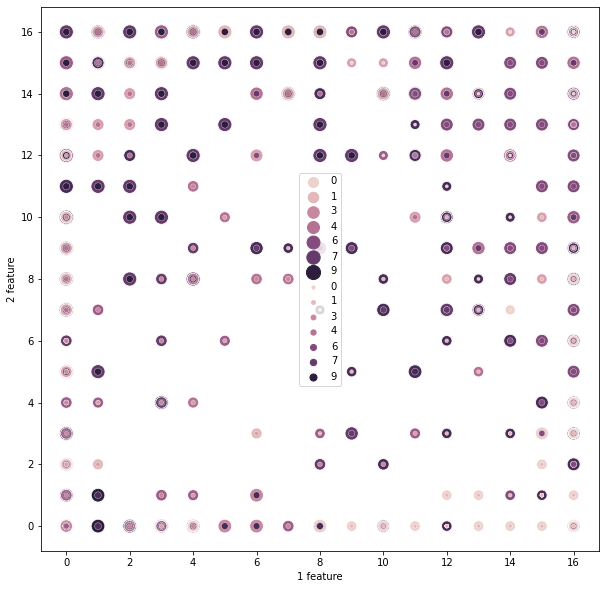

In [ ]:
kmeans = KMeans(n_clusters=K, random_state=0).fit(x_train)

y_pred=kmeans.predict(x_test)


plt.figure(figsize=(10,10))
sns.scatterplot(x_test[:,a],x_test[:,b],y_test,size=y_pred,sizes=(100, 200))
sns.scatterplot(x_test[:,a],x_test[:,b],y_pred,size=y_pred,sizes=(10, 50))
plt.xlabel('1 feature')
plt.ylabel('2 feature')

При кластеризации значения классов могут не совпадать с присвоенными значениями. Поэтому нельзя получить, например, classification_report(y_train,y_pred) для определения качества работы, но можно оценить графически - по сочетанию цветов объектов большего (реального класса) и меньшего (класса кластеризации) размера при их наложении. 

Поэтому анализ качества разделения проводится по другим показателям, которые можно разделить на внутренние и внешние.
К внутренним относятся расстояния внутри групп и между группами.
К внешним - повторяемость для датасета, например, при разных выборках, силуэт, однородность и полнота.

In [ ]:
#определим центры кластеров:
X=kmeans.cluster_centers_

#определим расстояния между кластерами по евклидовой метрике
R=np.zeros((K,K))
M=0
c=0
for i in range(K):
  for j in range(K):
    R[i,j]=np.sqrt(np.sum((X[i,:]-X[j,:])**2))
    if i>j:
      c+=1
      M=M+R[i,j]

#определим расстояния внутри классов по евклидовой метрике
M1=np.zeros((K))
c1=np.zeros((K))
for i in range(len(y_pred)):
  c1[y_pred[i]]+=1
  M1[y_pred[i]]=M1[y_pred[i]]+np.sqrt(np.sum((X[y_pred[i],:]-x_test[i,:])**2))

print('Внутренние:')
print(('Среднее расстояние между классами: {}.').format(M/c))
print('Среднее расстояние внутри классов:')
print(M1/c1)
print('Соотношение расстояния между классами и максимального расстояния внутри класса:')
print(M/c/np.max(M1/c1))
print('Для идеального разделения достаточно, чтобы это соотношение было больше двух')
print('Внешние:')
print(('Оценка коэффициента силуэта классов: {}').format(silhouette_score(x_test,y_pred)))
print('Оценка однородности, полноты и гармонического среднего между ними:')
print(homogeneity_completeness_v_measure(y_test,y_pred))

Внутренние:
Среднее расстояние между классами: 18.61030151019441.
Среднее расстояние внутри классов:
[ 9.22377873  8.51426198  8.22679826  7.89057684 10.31266015  7.94649507
  8.63845188  8.67368248  8.12803746  7.56657964]
Соотношение расстояния между классами и максимального расстояния внутри класса:
1.804607272990354
Для идеального разделения достаточно, чтобы это соотношение было больше двух
Внешние:
Оценка коэффициента силуэта классов: 0.23972069661984313
Оценка однородности, полноты и гармонического среднего между ними:
(0.4563069965520493, 0.4663318097529653, 0.461264941493716)


Для идеального разделения достаточно, чтобы соотношение расстояние между классами и расстояния внутри классов было больше двух.

Силуэт - это мера того, насколько хорошо образцы сгруппированы с образцами, которые похожи сами на себя. Модели кластеризации с высоким коэффициентом силуэта называются плотными, где образцы в одном кластере похожи друг на друга и хорошо разделены, где образцы в разных кластерах не очень похожи друг на друга.

Результат кластеризации удовлетворяет однородности, если все его кластеры содержат только точки данных, которые являются членами одного класса.

Результат кластеризации считается полнотой, если все точки данных, которые являются членами данного класса, являются элементами одного и того же кластера.

Метод Агломеративная кластеризация:

Этот иерархический метод может использовать различные метрики

Начнем с евклидовой

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


{'affinity': 'euclidean',
 'compute_full_tree': 'auto',
 'connectivity': None,
 'distance_threshold': None,
 'linkage': 'ward',
 'memory': None,
 'n_clusters': 10}

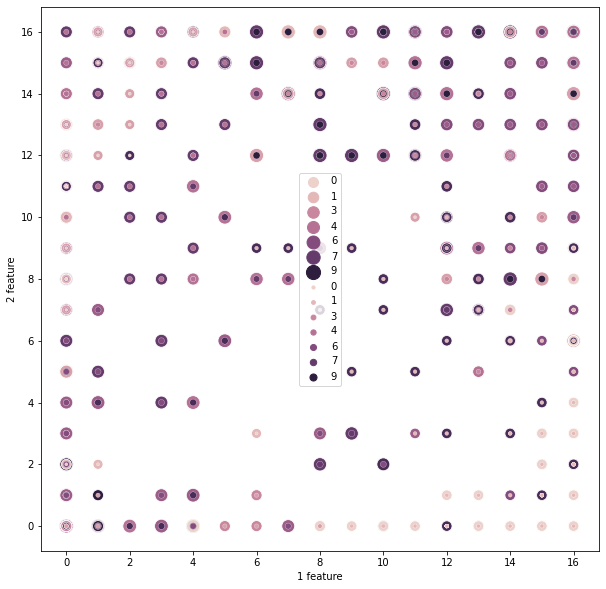

In [ ]:
Agg = AgglomerativeClustering(n_clusters=K,affinity='euclidean').fit(x_train)

y_pred=Agg.fit_predict(x_test)


plt.figure(figsize=(10,10))
sns.scatterplot(x_test[:,a],x_test[:,b],y_test,size=y_pred,sizes=(100, 200))
sns.scatterplot(x_test[:,a],x_test[:,b],y_pred,size=y_pred,sizes=(10, 50))
plt.xlabel('1 feature')
plt.ylabel('2 feature')

Agg.get_params()

При кластеризации значения классов могут не совпадать с присвоенными значениями. Поэтому нельзя получить, например, classification_report(y_train,y_pred) для определения качества работы, но можно оценить графически - по сочетанию цветов объектов большего (реального класса) и меньшего (класса кластеризации) размера при их наложении. 

Поэтому анализ качества разделения проводится по другим показателям, которые можно разделить на внутренние и внешние.
К внутренним относятся расстояния внутри групп и между группами.
К внешним - повторяемость для датасета, например, при разных выборках, силуэт, однородность и полнота.

In [ ]:
#определим центры кластеров:
X=x[0:K,:]
for i in range(K):
  for j in range(len(x_test.T)):
    X[i,j]=np.sum(x_test[y_pred==i,j])/len(y_pred[y_pred==i])


#определим расстояния между кластерами по евклидовой метрике
R=np.zeros((K,K))
M=0
c=0
for i in range(K):
  for j in range(K):
    R[i,j]=np.sqrt(np.sum((X[i,:]-X[j,:])**2))
    if i>j:
      c+=1
      M=M+R[i,j]

#определим расстояния внутри классов по евклидовой метрике
M1=np.zeros((K))
c1=np.zeros((K))
for i in range(len(y_pred)):
  c1[y_pred[i]]+=1
  M1[y_pred[i]]=M1[y_pred[i]]+np.sqrt(np.sum((X[y_pred[i],:]-x_test[i,:])**2))

print('Внутренние:')
print(('Среднее расстояние между классами: {}.').format(M/c))
print('Среднее расстояние внутри классов:')
print(M1/c1)
print('Соотношение расстояния между классами и максимального расстояния внутри класса:')
print(M/c/np.max(M1/c1))
print('Для идеального разделения достаточно, чтобы это соотношение было больше двух')
print('Внешние:')
print(('Оценка коэффициента силуэта классов: {}').format(silhouette_score(x_test,y_pred)))
print('Оценка однородности, полноты и гармонического среднего между ними:')
print(homogeneity_completeness_v_measure(y_test,y_pred))

Внутренние:
Среднее расстояние между классами: 18.180651336823384.
Среднее расстояние внутри классов:
[10.2691736   9.47609104  9.43671626  9.00335232  7.55680634  7.35022237
  7.89866294  8.14747299  6.76442285  8.88499155]
Соотношение расстояния между классами и максимального расстояния внутри класса:
1.7704103603448638
Для идеального разделения достаточно, чтобы это соотношение было больше двух
Внешние:
Оценка коэффициента силуэта классов: 0.1951166597988946
Оценка однородности, полноты и гармонического среднего между ними:
(0.45266200658409167, 0.46719109124272945, 0.4598118054280016)


Метод Агломеративная кластеризация:

Манхеттенская метрика

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


{'affinity': 'manhattan',
 'compute_full_tree': 'auto',
 'connectivity': None,
 'distance_threshold': None,
 'linkage': 'complete',
 'memory': None,
 'n_clusters': 10}

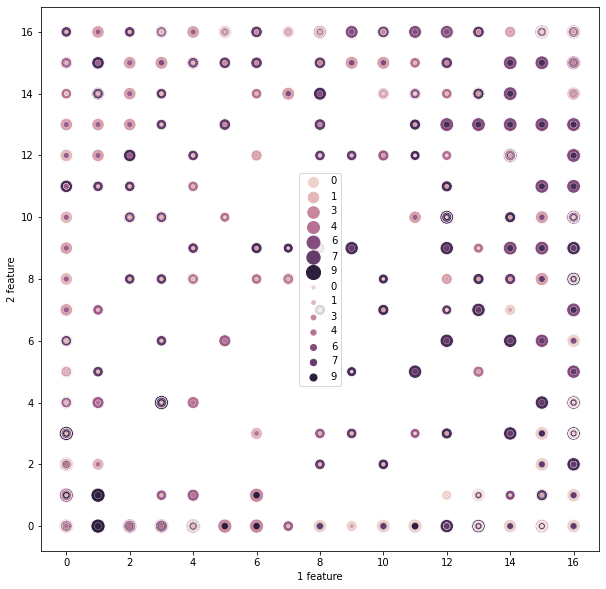

In [ ]:
Agg = AgglomerativeClustering(n_clusters=K,affinity='manhattan',linkage='complete').fit(x_train)

y_pred=Agg.fit_predict(x_test)


plt.figure(figsize=(10,10))
sns.scatterplot(x_test[:,a],x_test[:,b],y_test,size=y_pred,sizes=(100, 200))
sns.scatterplot(x_test[:,a],x_test[:,b],y_pred,size=y_pred,sizes=(10, 50))
plt.xlabel('1 feature')
plt.ylabel('2 feature')

Agg.get_params()

При кластеризации значения классов могут не совпадать с присвоенными значениями. Поэтому нельзя получить, например, classification_report(y_train,y_pred) для определения качества работы, но можно оценить графически - по сочетанию цветов объектов большего (реального класса) и меньшего (класса кластеризации) размера при их наложении. 

Поэтому анализ качества разделения проводится по другим показателям, которые можно разделить на внутренние и внешние.
К внутренним относятся расстояния внутри групп и между группами.
К внешним - повторяемость для датасета, например, при разных выборках, силуэт, однородность и полнота.

In [ ]:
#определим центры кластеров:
X=x[0:K,:]
for i in range(K):
  for j in range(len(x_test.T)):
    X[i,j]=np.sum(x_test[y_pred==i,j])/len(y_pred[y_pred==i])


#определим расстояния между кластерами по манхеттенской метрике
R=np.zeros((K,K))
M=0
c=0
for i in range(K):
  for j in range(K):
    R[i,j]=np.sum(np.abs((X[i,:]-X[j,:])))
    if i>j:
      c+=1
      M=M+R[i,j]

#определим расстояния внутри классов по манхеттенской метрике
M1=np.zeros((K))
c1=np.zeros((K))
for i in range(len(y_pred)):
  c1[y_pred[i]]+=1
  M1[y_pred[i]]=M1[y_pred[i]]+np.sum(np.abs((X[y_pred[i],:]-x_test[i,:])))

print('Внутренние:')
print(('Среднее расстояние между классами: {}.').format(M/c))
print('Среднее расстояние внутри классов:')
print(M1/c1)
print('Соотношение расстояния между классами и максимального расстояния внутри класса:')
print(M/c/np.max(M1/c1))
print('Для идеального разделения достаточно, чтобы это соотношение было больше двух')
print('Внешние:')
print(('Оценка коэффициента силуэта классов: {}').format(silhouette_score(x_test,y_pred)))
print('Оценка однородности, полноты и гармонического среднего между ними:')
print(homogeneity_completeness_v_measure(y_test,y_pred))

Внутренние:
Среднее расстояние между классами: 37.46280868991026.
Среднее расстояние внутри классов:
[24.00322494 19.7061157  22.4768     19.10870741 19.55191136 21.0011534
 23.29585799 21.85586777 16.16735537 18.34185579]
Соотношение расстояния между классами и максимального расстояния внутри класса:
1.5607406414881553
Для идеального разделения достаточно, чтобы это соотношение было больше двух
Внешние:
Оценка коэффициента силуэта классов: 0.1396962450853412
Оценка однородности, полноты и гармонического среднего между ними:
(0.4247005885799236, 0.43832045057180197, 0.43140304789657435)


Метод DBSCAN:

Этот неиерархический метод может использовать различные метрики

Начнем с евклидовой

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


{'algorithm': 'auto',
 'eps': 0.5,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 5,
 'n_jobs': None,
 'p': None}

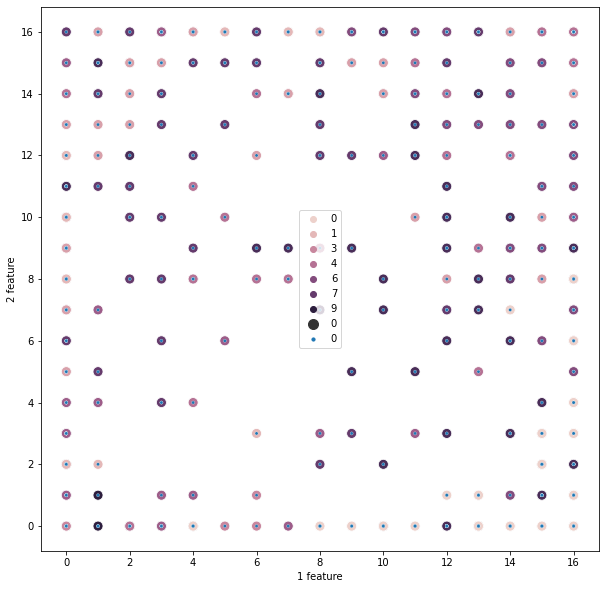

In [ ]:

Db = DBSCAN(eps = 0.5,metric = 'euclidean').fit(x_train)

y_pred=Db.fit_predict(x_test)

yy=np.unique(y_pred)
K=len(yy)
if np.min(yy)<0:
  y_pred=y_pred-np.min(yy)


plt.figure(figsize=(10,10))
sns.scatterplot(x_test[:,a],x_test[:,b],y_test,size=y_pred,sizes=(100, 200))
sns.scatterplot(x_test[:,a],x_test[:,b],y_pred,size=y_pred,sizes=(10, 50))
plt.xlabel('1 feature')
plt.ylabel('2 feature')

Db.get_params()



При кластеризации значения классов могут не совпадать с присвоенными значениями. Поэтому нельзя получить, например, classification_report(y_train,y_pred) для определения качества работы, но можно оценить графически - по сочетанию цветов объектов большего (реального класса) и меньшего (класса кластеризации) размера при их наложении. 

Поэтому анализ качества разделения проводится по другим показателям, которые можно разделить на внутренние и внешние.
К внутренним относятся расстояния внутри групп и между группами.
К внешним - повторяемость для датасета, например, при разных выборках, силуэт, однородность и полнота.

In [ ]:
#определим центры кластеров:
X=x[0:K,:]
for i in range(K):
  for j in range(len(x_test.T)):
    X[i,j]=np.sum(x_test[y_pred==i,j])/len(y_pred[y_pred==i])

if K>1:
#определим расстояния между кластерами по евклидовой метрике

  R=np.zeros((K,K))
  M=0
  c=0
  for i in range(K):
    for j in range(K):
      R[i,j]=np.sqrt(np.sum((X[i,:]-X[j,:])**2))
      if i>j:
        c+=1
        M=M+R[i,j]

#определим расстояния внутри классов по евклидовой метрике
  M1=np.zeros((K))
  c1=np.zeros((K))
  for i in range(len(y_pred)):
    c1[y_pred[i]]+=1
    M1[y_pred[i]]=M1[y_pred[i]]+np.sqrt(np.sum((X[y_pred[i],:]-x_test[i,:])**2))

  print('Внутренние:')
  print(('Среднее расстояние между классами: {}.').format(M/c))
  print('Среднее расстояние внутри классов:')
  print(M1/c1)
  print('Соотношение расстояния между классами и максимального расстояния внутри класса:')
  print(M/c/np.max(M1/c1))
  print('Для идеального разделения достаточно, чтобы это соотношение было больше двух')
  print('Внешние:')
  print(('Оценка коэффициента силуэта классов: {}').format(silhouette_score(x_test,y_pred)))
  print('Оценка однородности, полноты и гармонического среднего между ними:')
  print(homogeneity_completeness_v_measure(y_test,y_pred))

Внутренние:
Среднее расстояние внутри классов:
[15.09476165]
Соотношение расстояния между классами и максимального расстояния внутри класса:
Для идеального разделения достаточно, чтобы это соотношение было больше двух
Внешние:


ValueError: ignored

Метод DBSCAN:

Манхеттенская метрика

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


{'algorithm': 'auto',
 'eps': 0.5,
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'min_samples': 5,
 'n_jobs': None,
 'p': None}

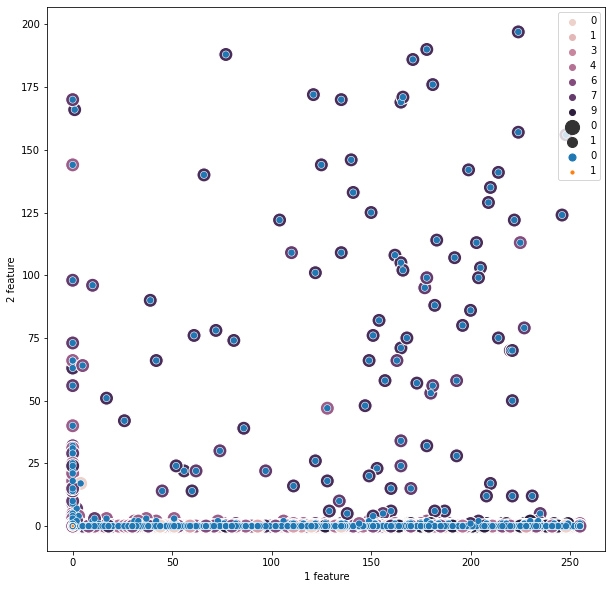

In [ ]:
Db = DBSCAN(eps = 0.5,metric = 'manhattan').fit(x_train)

y_pred=Db.fit_predict(x_test)

yy=np.unique(y_pred)
K=len(yy)
if np.min(yy)<0:
  y_pred=y_pred-np.min(yy)


plt.figure(figsize=(10,10))
sns.scatterplot(x_test[:,a],x_test[:,b],y_test,size=y_pred,sizes=(100, 200))
sns.scatterplot(x_test[:,a],x_test[:,b],y_pred,size=y_pred,sizes=(10, 50))
plt.xlabel('1 feature')
plt.ylabel('2 feature')

Db.get_params()

При кластеризации значения классов могут не совпадать с присвоенными значениями. Поэтому нельзя получить, например, classification_report(y_train,y_pred) для определения качества работы, но можно оценить графически - по сочетанию цветов объектов большего (реального класса) и меньшего (класса кластеризации) размера при их наложении. 

Поэтому анализ качества разделения проводится по другим показателям, которые можно разделить на внутренние и внешние.
К внутренним относятся расстояния внутри групп и между группами.
К внешним - повторяемость для датасета, например, при разных выборках, силуэт, однородность и полнота.

In [ ]:
#определим центры кластеров:
X=x[0:K,:]
for i in range(K):
  for j in range(len(x_test.T)):
    X[i,j]=np.sum(x_test[y_pred==i,j])/len(y_pred[y_pred==i])

if K>1:
  #определим расстояния между кластерами по манхеттенской метрике
  R=np.zeros((K,K))
  M=0
  c=0
  for i in range(K):
    for j in range(K):
      R[i,j]=np.sum(np.abs((X[i,:]-X[j,:])))
      if i>j:
        c+=1
        M=M+R[i,j]

  #определим расстояния внутри классов по манхеттенской метрике
  M1=np.zeros((K))
  c1=np.zeros((K))
  for i in range(len(y_pred)):
    c1[y_pred[i]]+=1
    M1[y_pred[i]]=M1[y_pred[i]]+np.sum(np.abs((X[y_pred[i],:]-x_test[i,:])))

  print('Внутренние:')
  print(('Среднее расстояние между классами: {}.').format(M/c))
  print('Среднее расстояние внутри классов:')
  print(M1/c1)
  print('Соотношение расстояния между классами и максимального расстояния внутри класса:')
  print(M/c/np.max(M1/c1))
  print('Для идеального разделения достаточно, чтобы это соотношение было больше двух')
  print('Внешние:')
  print(('Оценка коэффициента силуэта классов: {}').format(silhouette_score(x_test,y_pred)))
  print('Оценка однородности, полноты и гармонического среднего между ними:')
  print(homogeneity_completeness_v_measure(y_test,y_pred))